# Transcribe long audio

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/transcribe-long-audio](https://github.com/huseinzol05/malaya-speech/tree/master/example/transcribe-long-audio).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [2]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

Let say you want to transcribe a very long audio file, example,

In [3]:
from pydub import AudioSegment
import numpy as np

sr = 16000
sound = AudioSegment.from_file('speech/video/70_Peratus_Gaji_Rakyat_Malaysia_Dibelanjakan_Untuk_Barang_Keperluan.mp3')
samples = sound.set_frame_rate(sr).set_channels(1).get_array_of_samples()

In [4]:
samples = np.array(samples)
samples = malaya_speech.utils.astype.int_to_float(samples)

In [5]:
len(samples) / sr

110.106125

110 seconds.

In [6]:
import IPython.display as ipd

ipd.Audio(samples[:sr * 20], rate = sr)

Let's we try feed into Malaya-Speech ASR model.

### Load RNNT model

Read more about RNNT Speech-to-Text at https://malaya-speech.readthedocs.io/en/latest/load-stt-transducer-model.html

In [7]:
quantized_model = malaya_speech.stt.deep_transducer(model = 'small-conformer', quantized = True)

In [8]:
quantized_model(samples, decoder = 'greedy')

'hampir 70 peratus pendapatan bulanan rakyat negara ini dibelanjakan untuk barang keperluan perumahan dan pengangkutan laporan bani itu juga semakin rendah pendapatan rakyat semakin banyak dibelanjakan mereka untuk makanan-paling terkesan apabila berlaku kenakan harga barang untuk golongan kaya pula lagi tinggi pendapatan semakin banyak mereka menghabiskan masa lapang dengan melancong dan ke kelab kelab rekreasi perlu diberi perhatian dalam laporan itu ialah pendapatan rakyat malaysia yang statih ketika kau sari duk meningkat polis kelantan menghasilkan penduduk negeri tersebut waspada menghadapi gelombang kedua banjir edit yang ke berlaku 25 dan 26 haribulan ini ramai terutamanya yang mempunyai anak kecil agak macam wanita hamil m sentiasa bersiap sedia tidak akan berpindah pada bila-bila masa manakala di kota tinggi johor lebih 700 penduduk berlindung di pusat pemindahan di daerah itu dalam itu juga telah meragut nyawa pertama di daerah berkenaan selepas orang lelaki ditemui matilah 

As you can see, the output is not really good. The reason why here, we only trained samples less than 20 seconds to reduce memory consumption, so to solve this long problem, we need to split the sample using VAD, can read more at https://malaya-speech.readthedocs.io/en/latest/split-utterances.html

### Initate pipeline

In [9]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

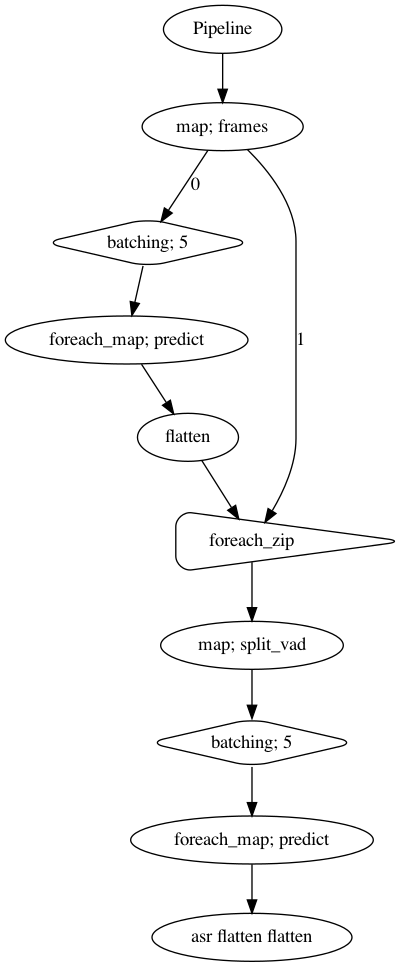

In [10]:
p = Pipeline()

frame = (
    p.map(malaya_speech.utils.generator.frames, frame_duration_ms = 30)
)

vad_map = frame.batching(5).foreach_map(vad.predict).flatten()
foreach = frame.foreach_zip(vad_map)
splitted = foreach.map(malaya_speech.split.split_vad)
asr_map = splitted.batching(5).foreach_map(quantized_model.predict, decoder = 'greedy').flatten(name = 'asr-flatten')
p.visualize()

In [14]:
%%time

result = p(samples)
result.keys()

CPU times: user 1min 34s, sys: 27.5 s, total: 2min 2s
Wall time: 25.8 s


dict_keys(['frames', 'batching', 'predict', 'flatten', 'foreach_zip', 'split_vad', 'flatten_asr-flatten'])

In [12]:
result['flatten_asr-flatten']

['hampir 70 peratus pendapatan bulan anak rakyat negara ini dibelanjakan untuk barang keperluan perumahan dan pengangkutan',
 'duduk laporan bank dunia itu juga semakin rendah pendapatan rakyat semakin banyak dibelanjakan mereka untuk makanan ia secara langsung jadikan mereka paling terkesan',
 'apabila berlaku kenakan harga barang untuk golongan kaya pula lagi tinggi pendapatan semakin banyak mereka menghabiskan masa lapang dengan melancong dan ke kelab kelab rekreasi',
 'namun yang turut perlu diberi perhatian dalam laporan itu ialah pendapatan rakyat malaysia yang statih ketika kau sari hidup meningkat',
 'polis kelantan menasarkan penduduk negeri tersebut waspada menghadapi gelombang kedua banjir',
 'dijangka berlaku 25 dan 26 haribulan ini orang ramai terutamanya yang mempunyai anak kecil agak majan wanita hamil m sentiasa bersiap sedia',
 'tidak akan berpindah pada bila-bila masa manakala di kota tinggi johor',
 'lebih 700 penduduk berlindung di lima pusat pemindahan di daerah it

In [17]:
import IPython.display as ipd
ipd.Audio(result['split_vad'][-3].array, rate = 16000)